model comparison by WAIC or LOO-CV

https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/model_comparison.html

In [44]:
import numpy as np
import arviz as az
import pymc as pm
import pytensor.tensor as pt
from pytensor.printing import Print
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Prepare datasets

In [32]:
penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

In [33]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [34]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,2008.042042
std,5.468668,1.969235,14.015765,805.215802,0.812944
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.500000,15.600000,190.000000,3550.000000,2007.000000
50%,44.500000,17.300000,197.000000,4050.000000,2008.000000
75%,48.600000,18.700000,213.000000,4775.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


## Model building

### Pooled Model

In [35]:
feature_ct = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), ["species", "island", "sex"]),
        ("numeric", "passthrough", ["bill_length_mm", "flipper_length_mm", "bill_depth_mm"]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


feat_df = pd.DataFrame(feature_ct.fit_transform(penguins), columns=feature_ct.get_feature_names_out())
target = penguins["body_mass_g"]
display(feat_df.head())

,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_male,bill_length_mm,flipper_length_mm,bill_depth_mm
0,0.0,0.0,0.0,1.0,1.0,39.1,181.0,18.7
1,0.0,0.0,0.0,1.0,0.0,39.5,186.0,17.4
2,0.0,0.0,0.0,1.0,0.0,40.3,195.0,18.0
3,0.0,0.0,0.0,1.0,0.0,36.7,193.0,19.3
4,0.0,0.0,0.0,1.0,1.0,39.3,190.0,20.6


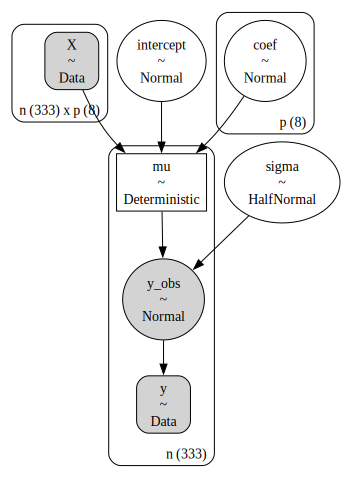

In [36]:
with pm.Model() as model_pooled:
    # set coords
    model_pooled.add_coord("n", feat_df.index.to_list())
    model_pooled.add_coord("p", feat_df.columns.to_list())

    # data
    X = pm.Data("X", feat_df, dims=("n", "p"))
    y = pm.Data("y", target, dims=("n"))

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    coef = pm.Normal("coef", mu=0, sigma=100, dims=("p"))
    sigma = pm.HalfNormal("sigma", sigma=100)

    # mu
    mu = pm.Deterministic(
        "mu",
        intercept + pt.dot(X, coef),
        dims=("n")
    )

    # likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y, dims=("n"))

pm.model_to_graphviz(model_pooled)

Sampling: [coef, intercept, sigma, y_obs]


<Axes: xlabel='y_obs'>

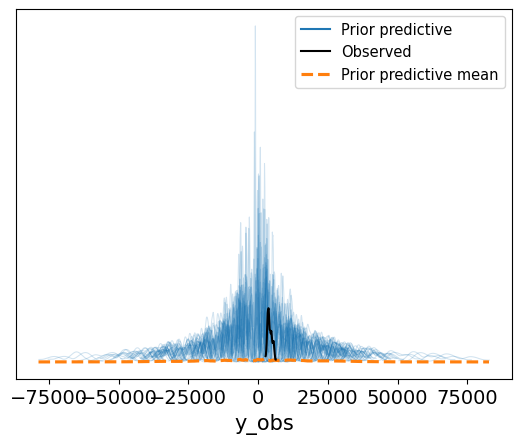

In [37]:
# prior predictive check
# 体重は非負なので、負の値をとらないようにすべき？
with model_pooled:
    prior_pooled = pm.sample_prior_predictive()
az.plot_ppc(prior_pooled, group="prior", observed=True)

In [38]:
# posterior sampling
with model_pooled:
    trace_pooled = pm.sample(1000, tune=1000, return_inferencedata=True, nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

az.summary(trace_pooled, var_names=["intercept", "coef", "sigma"])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-87.609,99.729,-286.477,85.156,1.544,1.476,4166.0,2408.0,1.0
coef[species_Chinstrap],-248.422,62.285,-366.588,-132.884,1.244,0.879,2490.0,3030.0,1.0
coef[species_Gentoo],466.025,81.423,318.187,622.661,1.569,1.120,2699.0,2921.0,1.0
coef[island_Dream],-115.762,47.988,-205.353,-29.689,0.780,0.554,3791.0,2897.0,1.0
coef[island_Torgersen],-94.493,51.414,-193.623,1.647,0.826,0.641,3903.0,2616.0,1.0
coef[sex_male],457.370,35.550,392.612,525.637,0.586,0.416,3685.0,3182.0,1.0
coef[bill_length_mm],23.252,5.974,12.500,34.514,0.120,0.085,2487.0,2968.0,1.0
coef[flipper_length_mm],17.589,1.753,14.449,20.968,0.039,0.027,2058.0,2260.0,1.0
coef[bill_depth_mm],-32.117,13.631,-59.514,-8.800,0.284,0.201,2303.0,2742.0,1.0
sigma,298.453,11.953,277.095,321.582,0.187,0.132,4113.0,2893.0,1.0


array([[<Axes: title={'center': 'coef\nspecies_Chinstrap'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\nspecies_Gentoo'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\nisland_Dream'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'coef\nisland_Torgersen'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\nsex_male'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\nbill_length_mm'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'coef\nflipper_length_mm'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\nbill_depth_mm'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'intercept'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
    

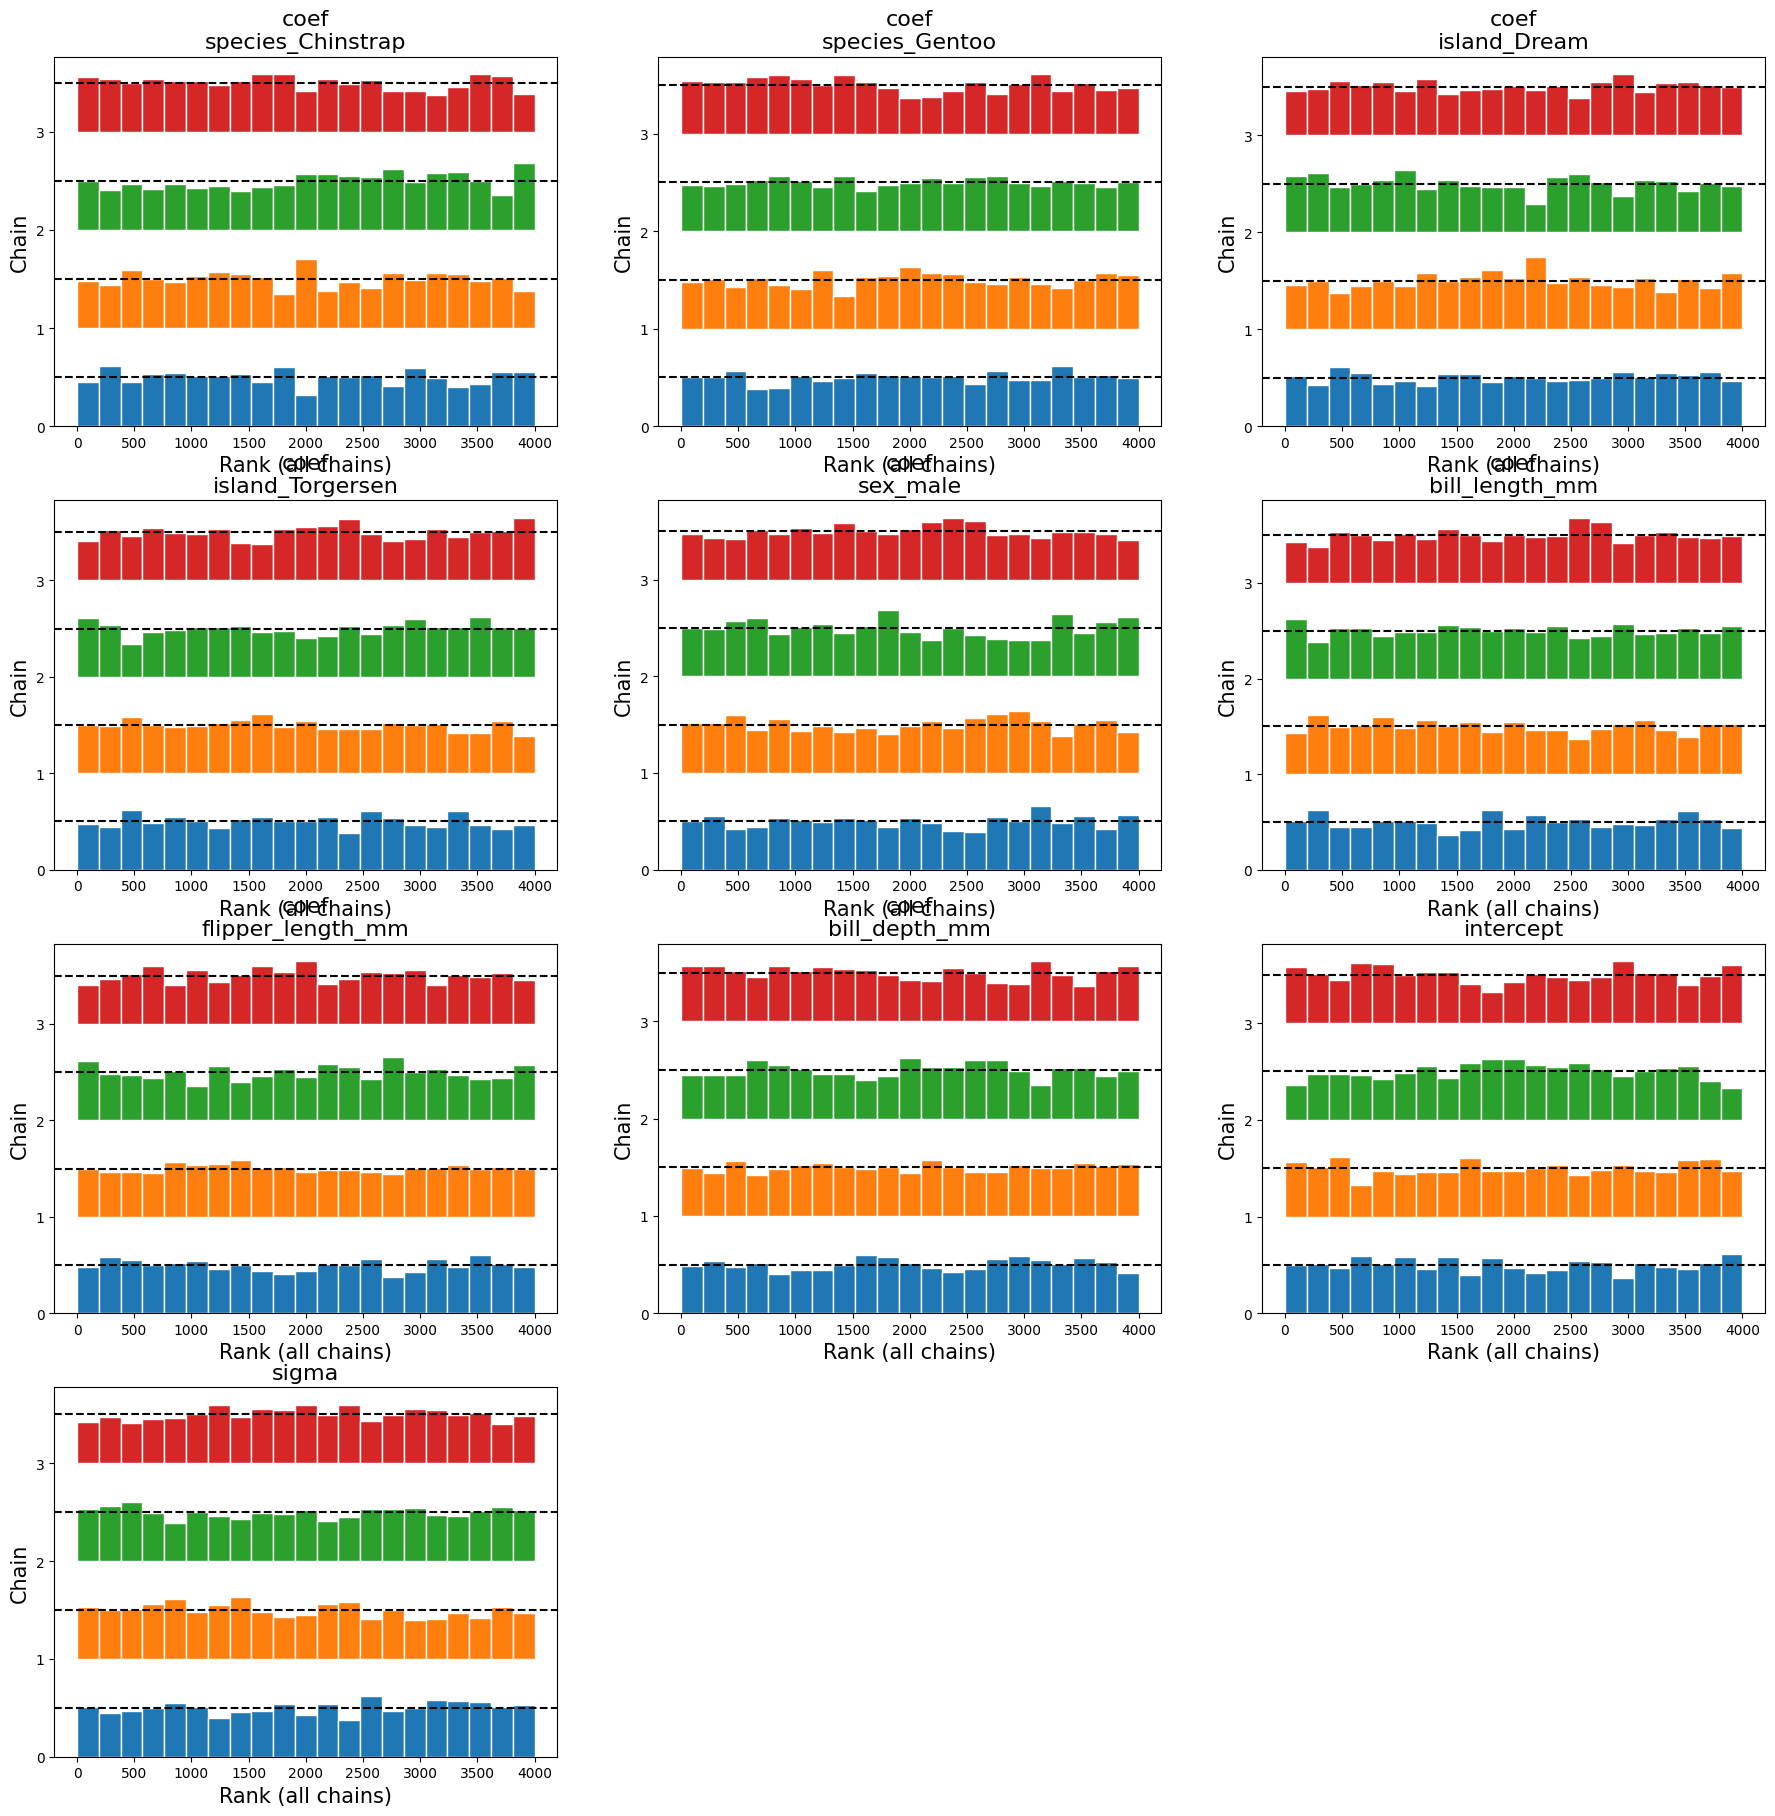

In [39]:
az.plot_rank(trace_pooled, var_names=["coef", "intercept", "sigma"])

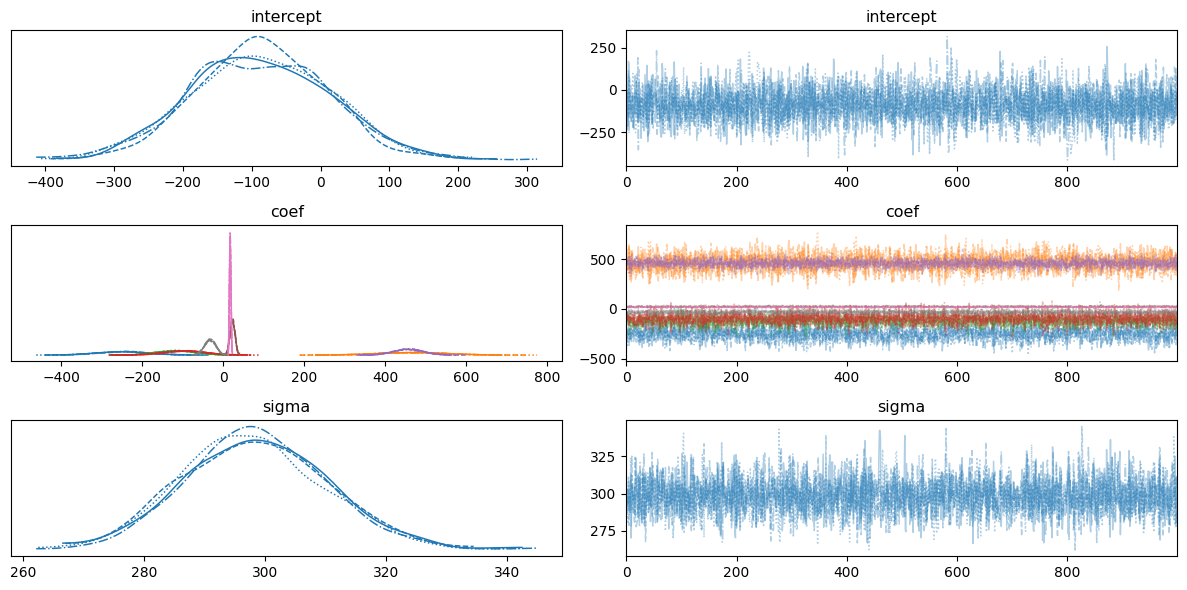

In [40]:
az.plot_trace(trace_pooled, var_names=["intercept", "coef", "sigma"])
plt.tight_layout()

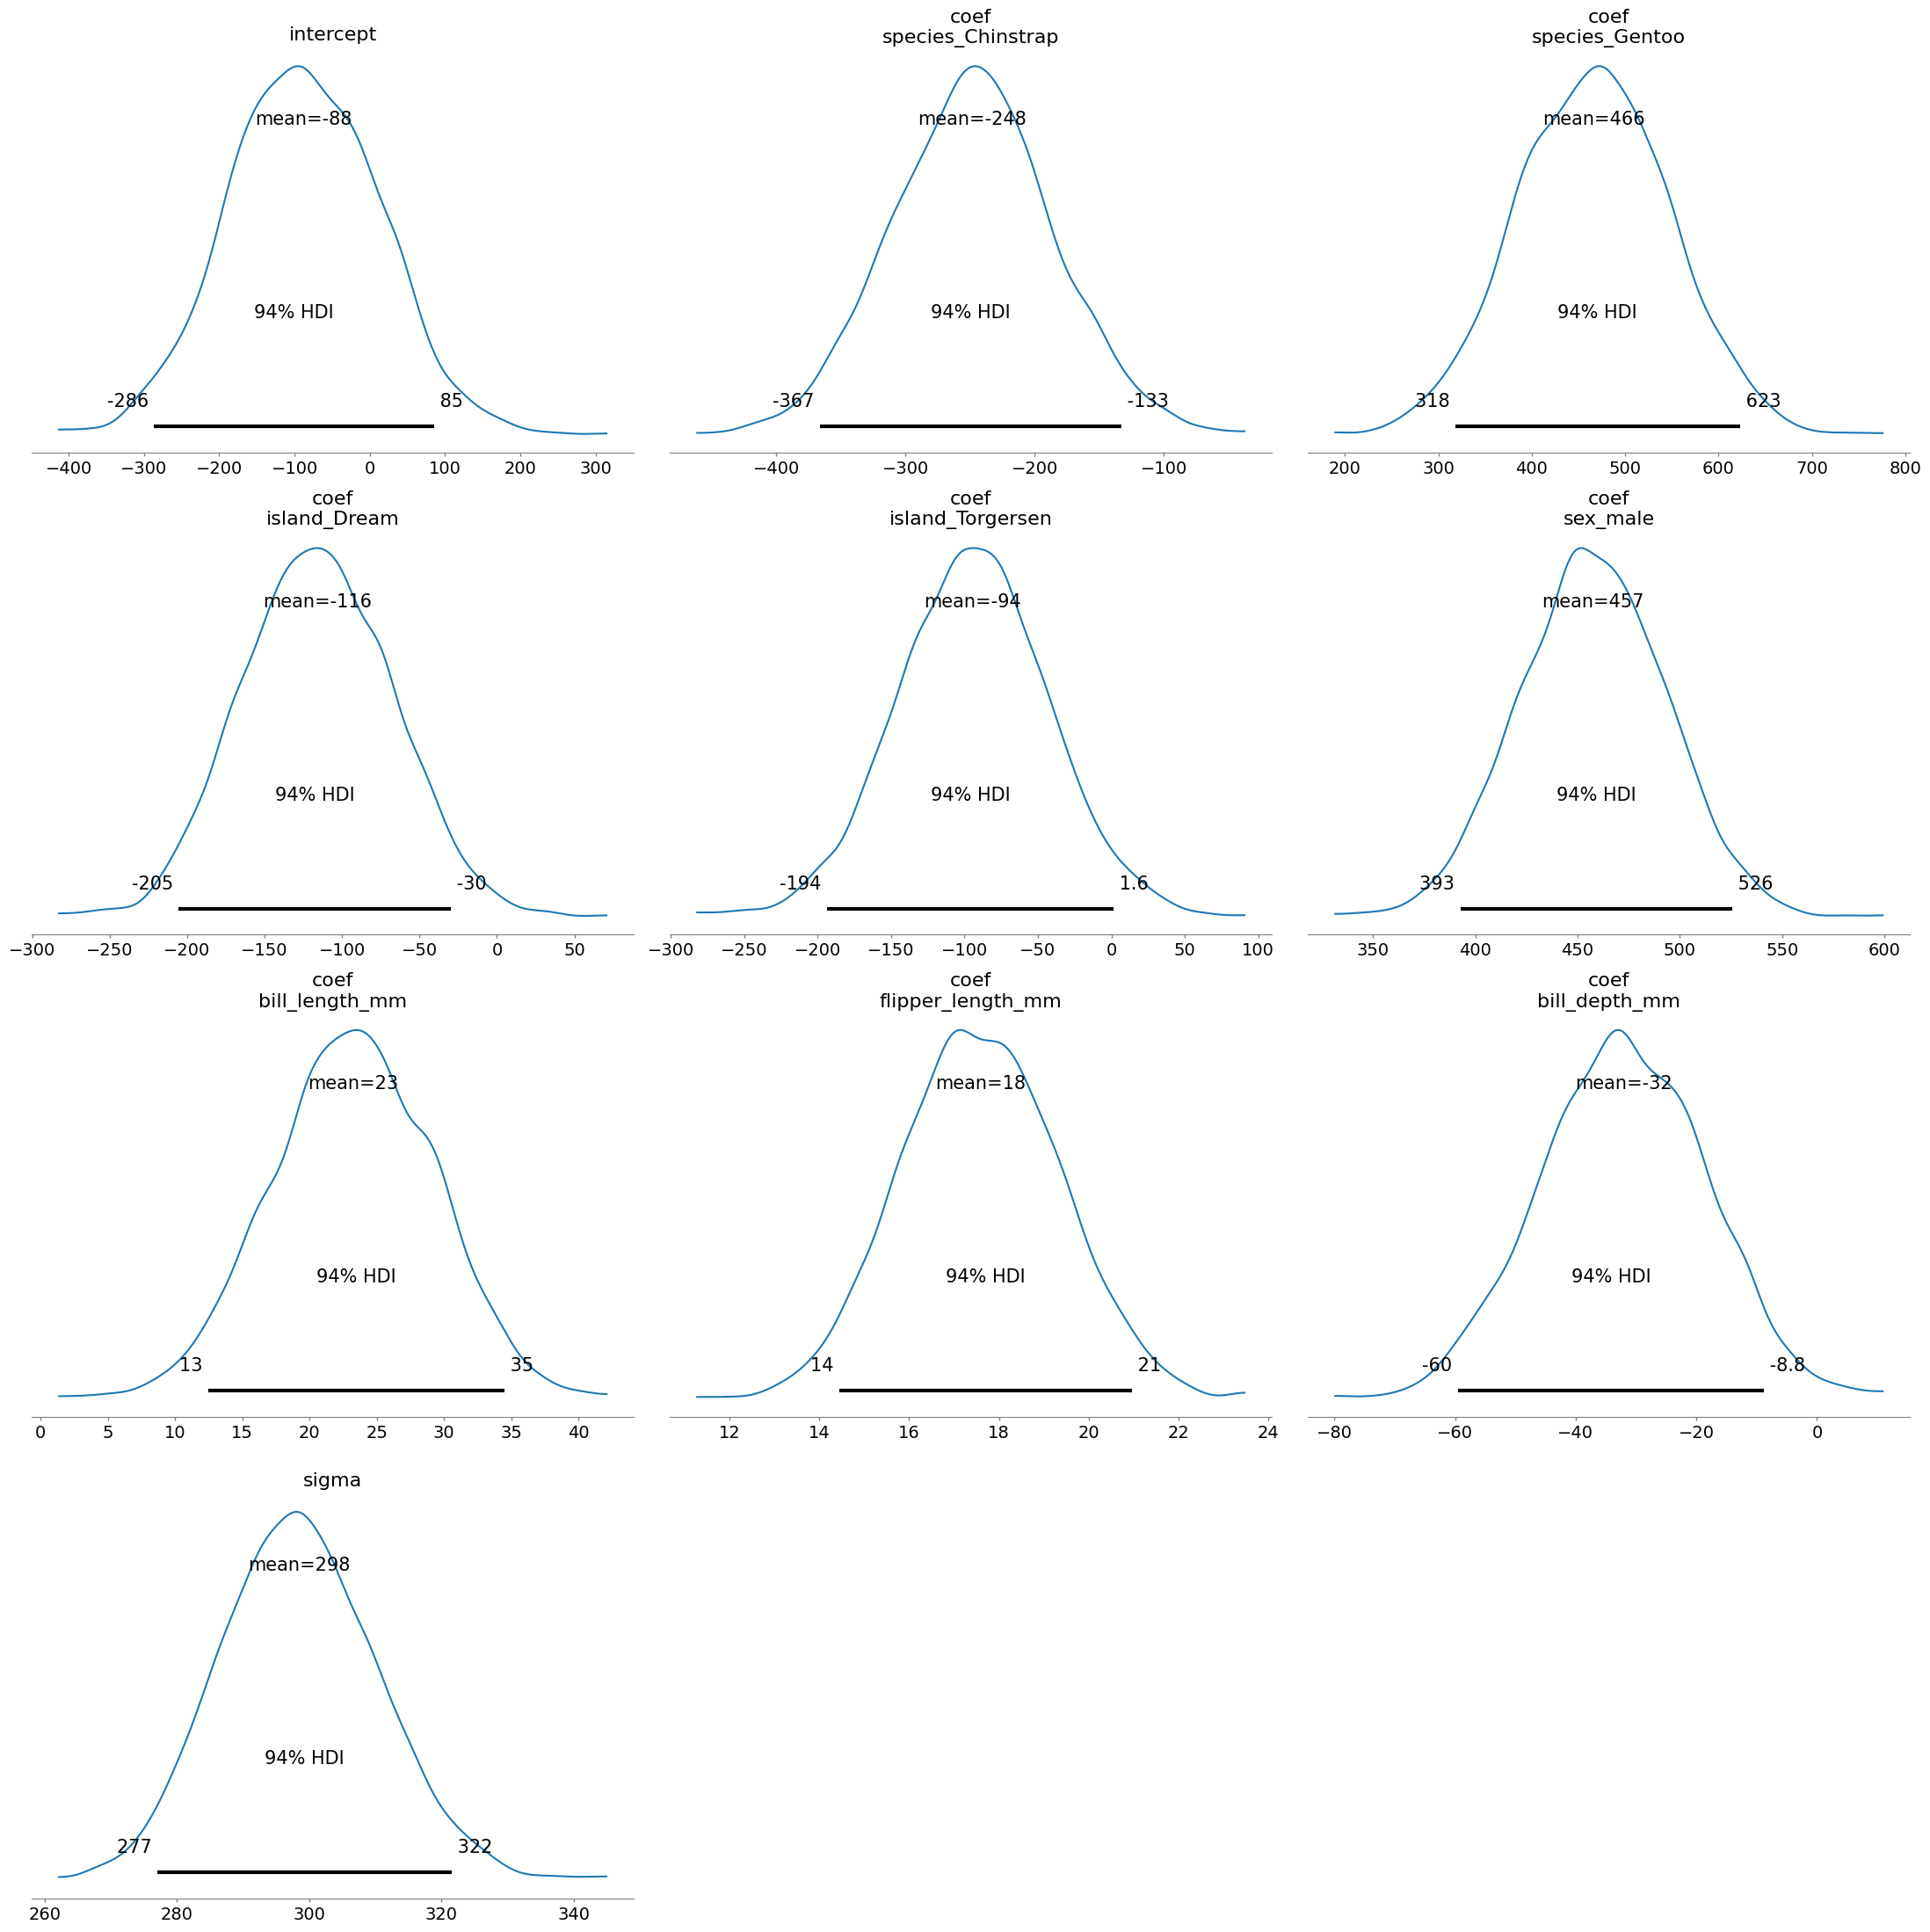

In [41]:
az.plot_posterior(trace_pooled, var_names=["intercept", "coef", "sigma"])
plt.tight_layout()

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

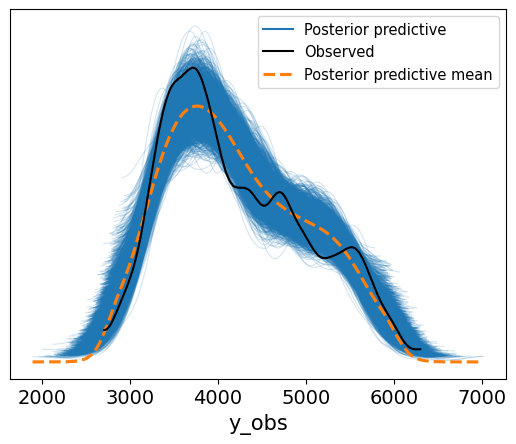

In [42]:
# posterior predictive check
with model_pooled:
    ppc_pooled = pm.sample_posterior_predictive(trace_pooled, var_names=["y_obs"])

az.plot_ppc(ppc_pooled, observed=True)

### Hierarchical model

In [43]:
feature_ct = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), ["island", "sex"]),
        ("numeric", "passthrough", ["bill_length_mm", "flipper_length_mm", "bill_depth_mm"]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

species_encoder = OrdinalEncoder()


feat_df = pd.DataFrame(feature_ct.fit_transform(penguins), columns=feature_ct.get_feature_names_out())
target = penguins["body_mass_g"]
species_ser = species_encoder.fit_transform(penguins[["species"]]).flatten().astype(int)
display(feat_df.head())

,island_Dream,island_Torgersen,sex_male,bill_length_mm,flipper_length_mm,bill_depth_mm
0,0.0,1.0,1.0,39.1,181.0,18.7
1,0.0,1.0,0.0,39.5,186.0,17.4
2,0.0,1.0,0.0,40.3,195.0,18.0
3,0.0,1.0,0.0,36.7,193.0,19.3
4,0.0,1.0,1.0,39.3,190.0,20.6


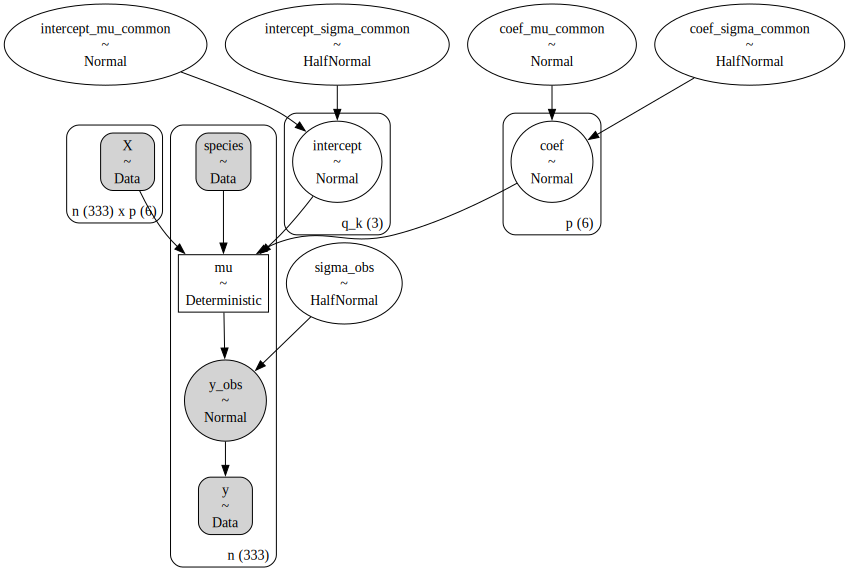

In [ ]:
with pm.Model() as model_hierarchy:
    # coords
    model_hierarchy.add_coord("n", feat_df.index.to_list())
    model_hierarchy.add_coord("p", feat_df.columns.to_list())
    model_hierarchy.add_coord("q_k", np.unique(species_ser))

    # data
    X = pm.Data("X", feat_df, dims=("n", "p"))
    y = pm.Data("y", target, dims=("n"))
    species = pm.Data("species", species_ser, dims=("n"))

    # prior
    intercept_mu = pm.Normal("intercept_mu_common", mu=0, sigma=100, dims=("q_k"))
    intercept_sigma = pm.HalfNormal("intercept_sigma_common", sigma=100, dims=("q_k"))
    coef_mu_common = pm.Normal("coef_mu_common", mu=0, sigma=100, dims=("p"))
    coef_sigma_common = pm.HalfNormal("coef_sigma_common", sigma=100, dims=("p"))
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=100)

    # species specific coefficients and intercepts
    intercept= pm.Normal(
        "intercept",
        mu=intercept_mu,
        sigma=intercept_sigma,
        dims=("q_k")
        )
    coef = pm.Normal(
        "coef",
        mu=coef_mu_common,
        sigma=coef_sigma_common,
        dims=("p")
        )

    # calc mu
    mu = pm.Deterministic(
        "mu",
        X @ coef + intercept[species],
        dims=("n")
    )

    # likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma_obs, observed=y, dims=("n"))

pm.model_to_graphviz(model_hierarchy)

### Separate model (by species)

In [18]:
feature_ct = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), ["island", "sex"]),
        ("numeric", "passthrough", ["bill_length_mm", "flipper_length_mm", "bill_depth_mm"]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

species_encoder = OrdinalEncoder()


feat_df = pd.DataFrame(feature_ct.fit_transform(penguins), columns=feature_ct.get_feature_names_out())
target = penguins["body_mass_g"]
species_ser = species_encoder.fit_transform(penguins[["species"]]).flatten().astype(int)
display(feat_df.head())

,island_Dream,island_Torgersen,sex_male,bill_length_mm,flipper_length_mm,bill_depth_mm
0,0.0,1.0,1.0,39.1,181.0,18.7
1,0.0,1.0,0.0,39.5,186.0,17.4
2,0.0,1.0,0.0,40.3,195.0,18.0
3,0.0,1.0,0.0,36.7,193.0,19.3
4,0.0,1.0,1.0,39.3,190.0,20.6


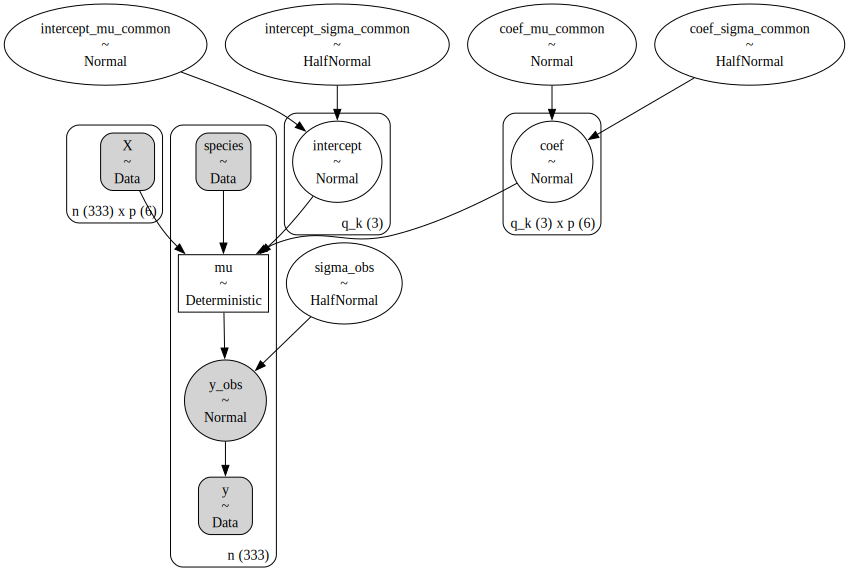

In [ ]:
with pm.Model() as model_separate:
    # coords
    model_separate.add_coord("n", feat_df.index.to_list())
    model_separate.add_coord("p", feat_df.columns.to_list())
    model_separate.add_coord("q_k", np.unique(species_ser))

    # data
    X = pm.Data("X", feat_df, dims=("n", "p"))
    y = pm.Data("y", target, dims=("n"))
    species = pm.Data("species", species_ser, dims=("n"))

    # prior
    intercept_mu_common = pm.Normal("intercept_mu", mu=0, sigma=100, dims=("q_k"))
    intercept_sigma_common = pm.HalfNormal("intercept_sigma", sigma=100, dims=("q_k"))
    coef_mu_common = pm.Normal("coef_mu_common", mu=0, sigma=100, dims=("q_k", "p"))
    coef_sigma_common = pm.HalfNormal("coef_sigma_common", sigma=100)
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=100)

    # species specific coefficients and intercepts
    intercept= pm.Normal(
        "intercept",
        mu=intercept_mu_common,
        sigma=intercept_sigma_common,
        dims=("q_k")
        )
    coef = pm.Normal(
        "coef",
        mu=coef_mu_common,
        sigma=coef_sigma_common,
        dims=("q_k", "p")
        )

    # calc mu
    mu = pm.Deterministic(
        "mu",
        pt.sum(X * coef[species], axis=1) + intercept[species],
        dims=("n")
    )

    # likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma_obs, observed=y, dims=("n"))

pm.model_to_graphviz(model_separate)

Sampling: [coef, coef_mu_common, coef_sigma_common, intercept, intercept_mu_common, intercept_sigma_common, sigma_obs, y_obs]


<Axes: xlabel='y_obs'>

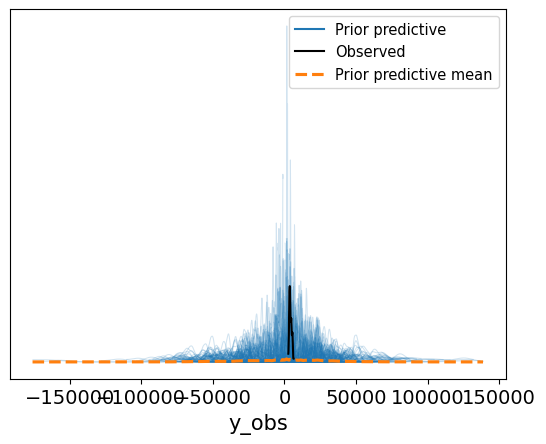

In [22]:
# prior predictive check
with model_separate:
    prior_separate = pm.sample_prior_predictive()

az.plot_ppc(prior_separate, group="prior", observed=True)

In [ ]:
# posterior sampling
with model_separate:
    trace_separate = pm.sample(2000, tune=1000, return_inferencedata=True, nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

az.summary(trace_separate, var_names=["intercept", "coef", "sigma_obs"])

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[0],-81.919,146.508,-352.062,187.594,2.381,1.904,3915.0,3795.0,1.0
intercept[1],-79.608,147.907,-365.640,185.453,2.345,2.116,4174.0,3829.0,1.0
intercept[2],-68.493,144.273,-323.125,216.211,2.290,1.742,4032.0,4206.0,1.0
"coef[0, island_Dream]",7.562,53.852,-91.453,110.749,0.700,0.557,5919.0,6086.0,1.0
"coef[0, island_Torgersen]",-11.794,55.895,-123.177,85.756,0.669,0.603,6971.0,5880.0,1.0
"coef[0, sex_male]",443.518,55.923,332.949,544.628,0.737,0.521,5755.0,5460.0,1.0
"coef[0, bill_length_mm]",19.579,10.368,0.315,38.999,0.137,0.102,5741.0,5513.0,1.0
"coef[0, flipper_length_mm]",8.691,2.746,3.850,14.064,0.041,0.029,4463.0,5103.0,1.0
"coef[0, bill_depth_mm]",63.039,21.740,23.450,104.543,0.279,0.197,6066.0,5954.0,1.0
"coef[1, island_Dream]",26.702,169.002,-288.841,348.922,1.930,1.916,7853.0,5532.0,1.0


array([[<Axes: title={'center': 'intercept\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'intercept\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'intercept\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\n0, island_Dream'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'coef\n0, island_Torgersen'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\n0, sex_male'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\n0, bill_length_mm'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\n0, flipper_length_mm'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'coef\n0, bill_depth_mm'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'coef\n1, island_Dream'}, xlabel='Rank (all chains)', ylab

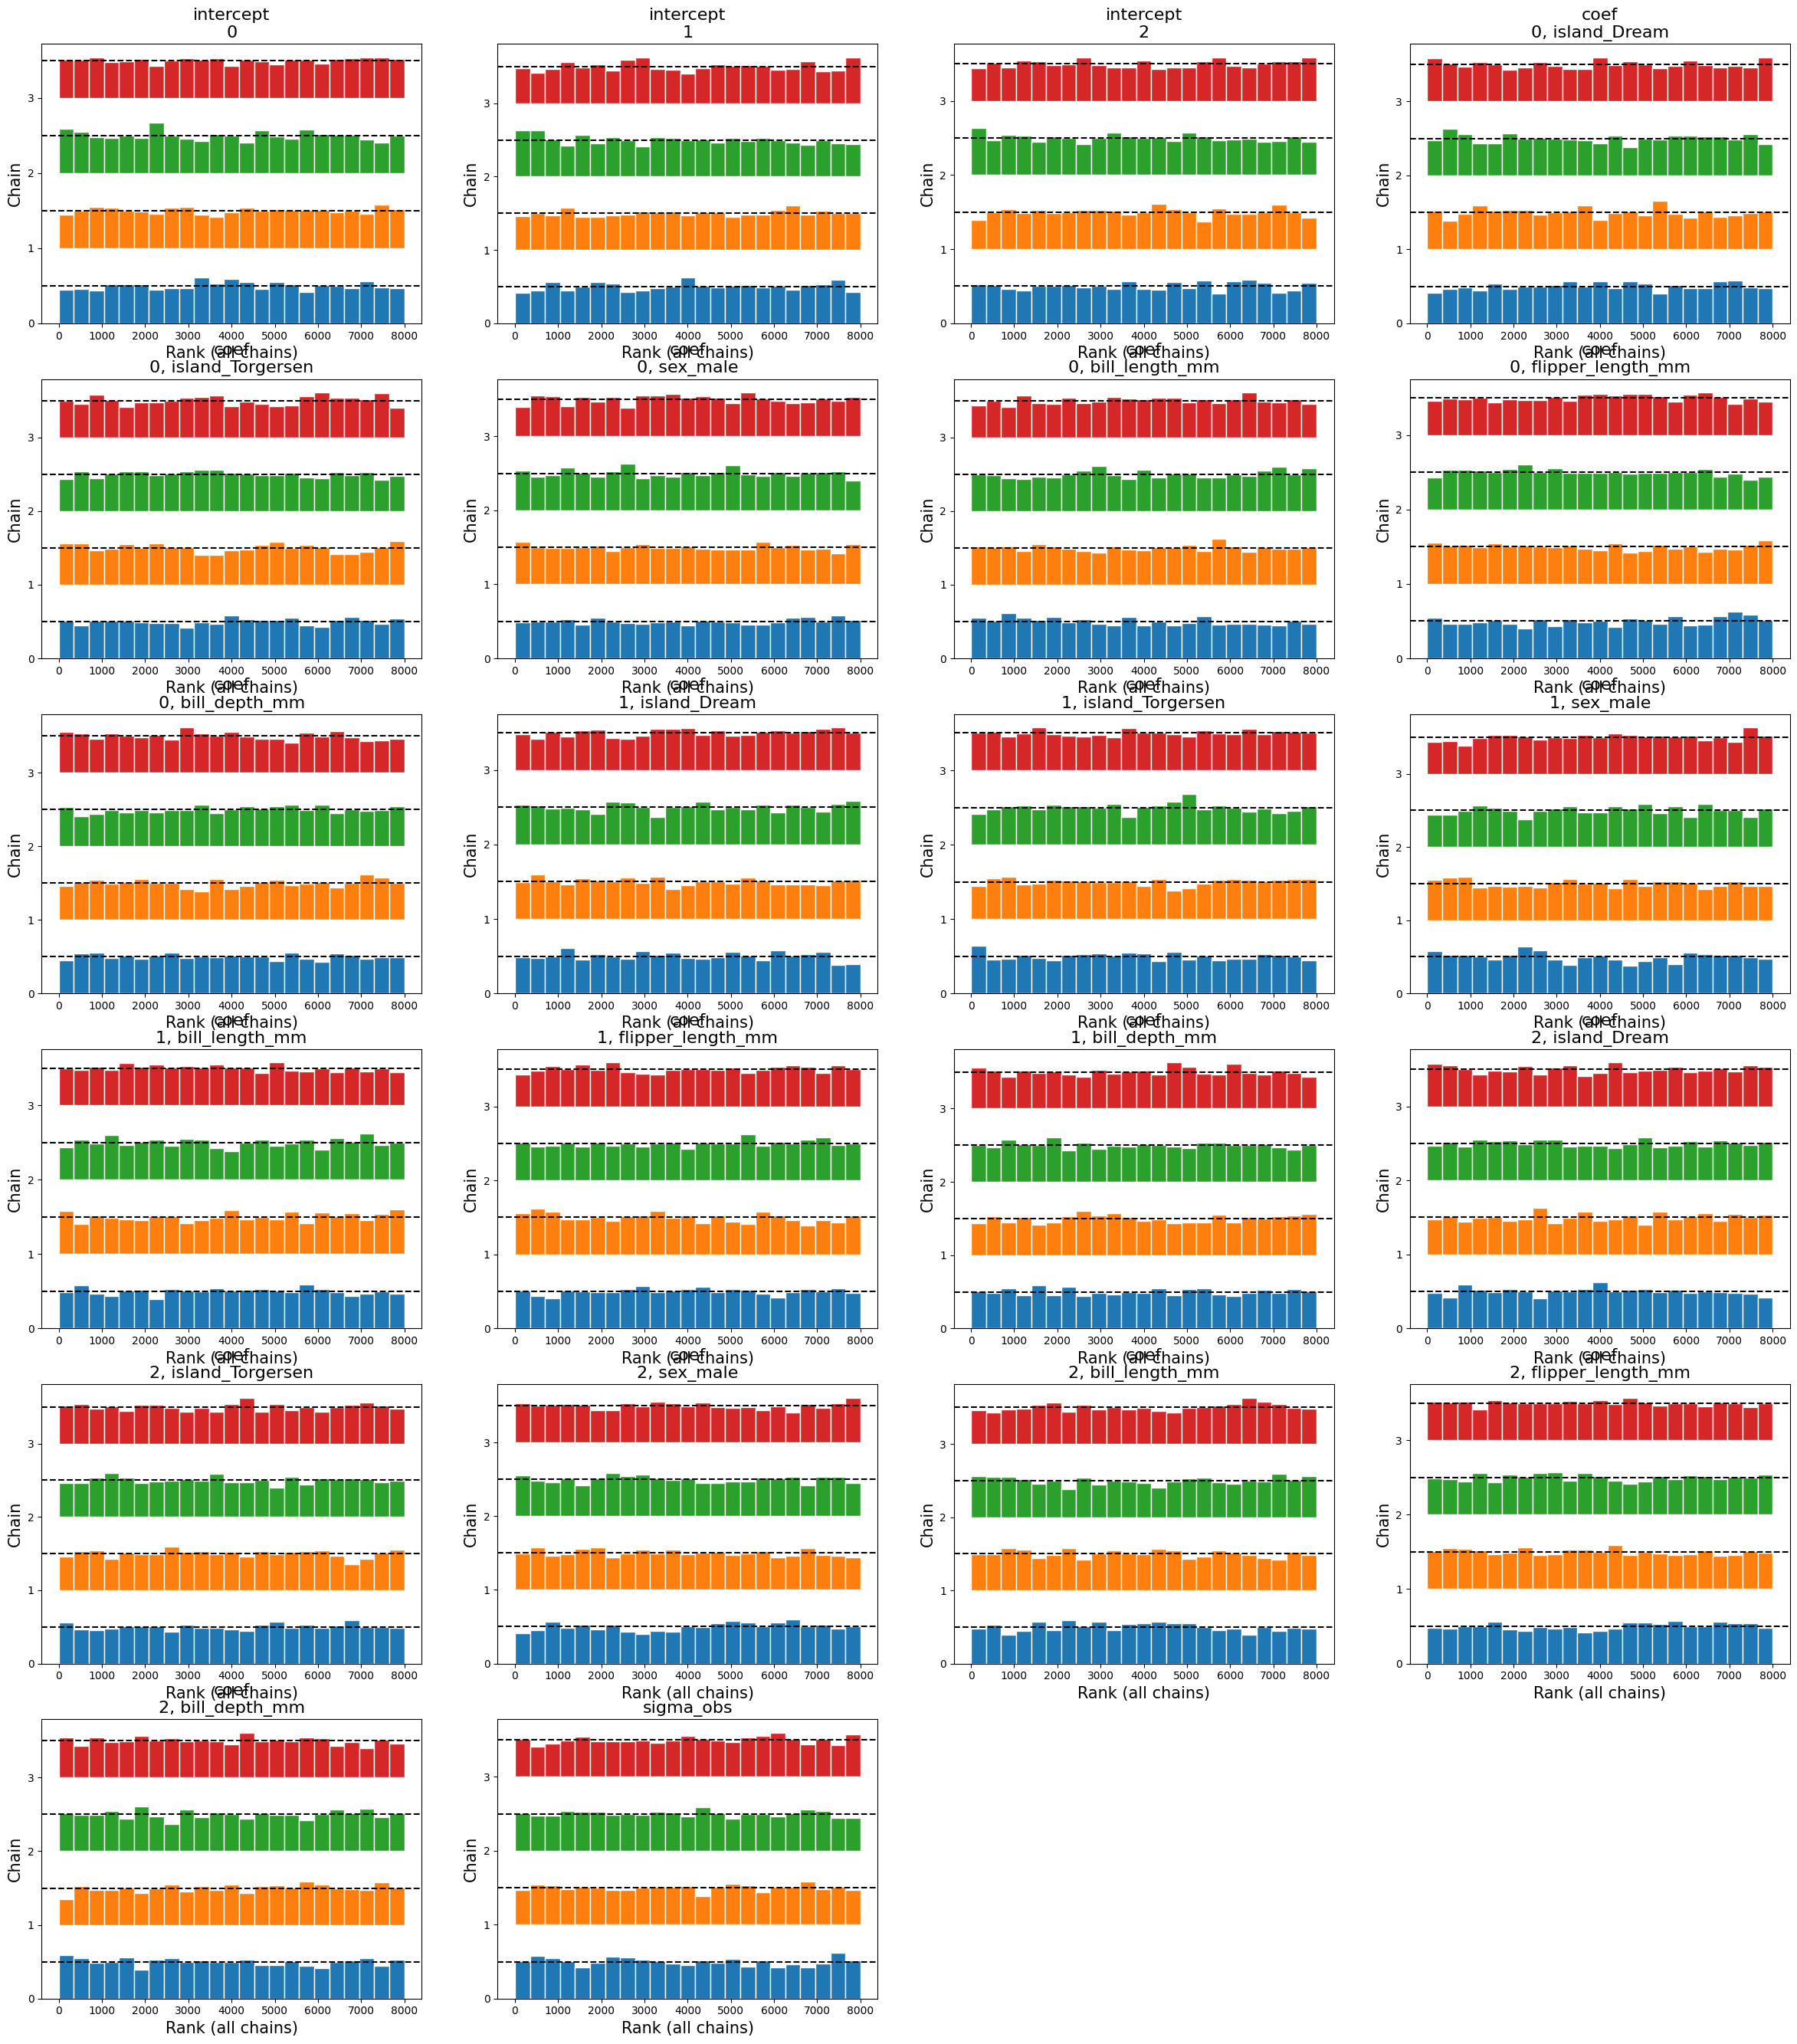

In [ ]:
# rank plot
az.plot_rank(trace_separate, var_names=["intercept", "coef", "sigma_obs"])

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coef'}>,
        <Axes: title={'center': 'coef'}>],
       [<Axes: title={'center': 'sigma_obs'}>,
        <Axes: title={'center': 'sigma_obs'}>]], dtype=object)

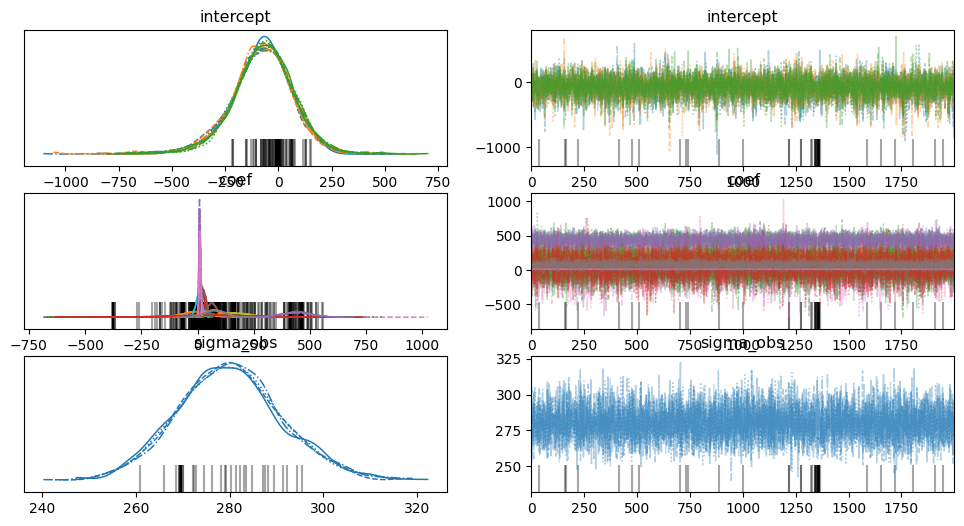

In [ ]:
# trace plot
az.plot_trace(trace_separate, var_names=["intercept", "coef", "sigma_obs"])

array([[<Axes: title={'center': 'intercept\n0'}>,
        <Axes: title={'center': 'intercept\n1'}>,
        <Axes: title={'center': 'intercept\n2'}>,
        <Axes: title={'center': 'coef\n0, island_Dream'}>],
       [<Axes: title={'center': 'coef\n0, island_Torgersen'}>,
        <Axes: title={'center': 'coef\n0, sex_male'}>,
        <Axes: title={'center': 'coef\n0, bill_length_mm'}>,
        <Axes: title={'center': 'coef\n0, flipper_length_mm'}>],
       [<Axes: title={'center': 'coef\n0, bill_depth_mm'}>,
        <Axes: title={'center': 'coef\n1, island_Dream'}>,
        <Axes: title={'center': 'coef\n1, island_Torgersen'}>,
        <Axes: title={'center': 'coef\n1, sex_male'}>],
       [<Axes: title={'center': 'coef\n1, bill_length_mm'}>,
        <Axes: title={'center': 'coef\n1, flipper_length_mm'}>,
        <Axes: title={'center': 'coef\n1, bill_depth_mm'}>,
        <Axes: title={'center': 'coef\n2, island_Dream'}>],
       [<Axes: title={'center': 'coef\n2, island_Torgersen'}>,


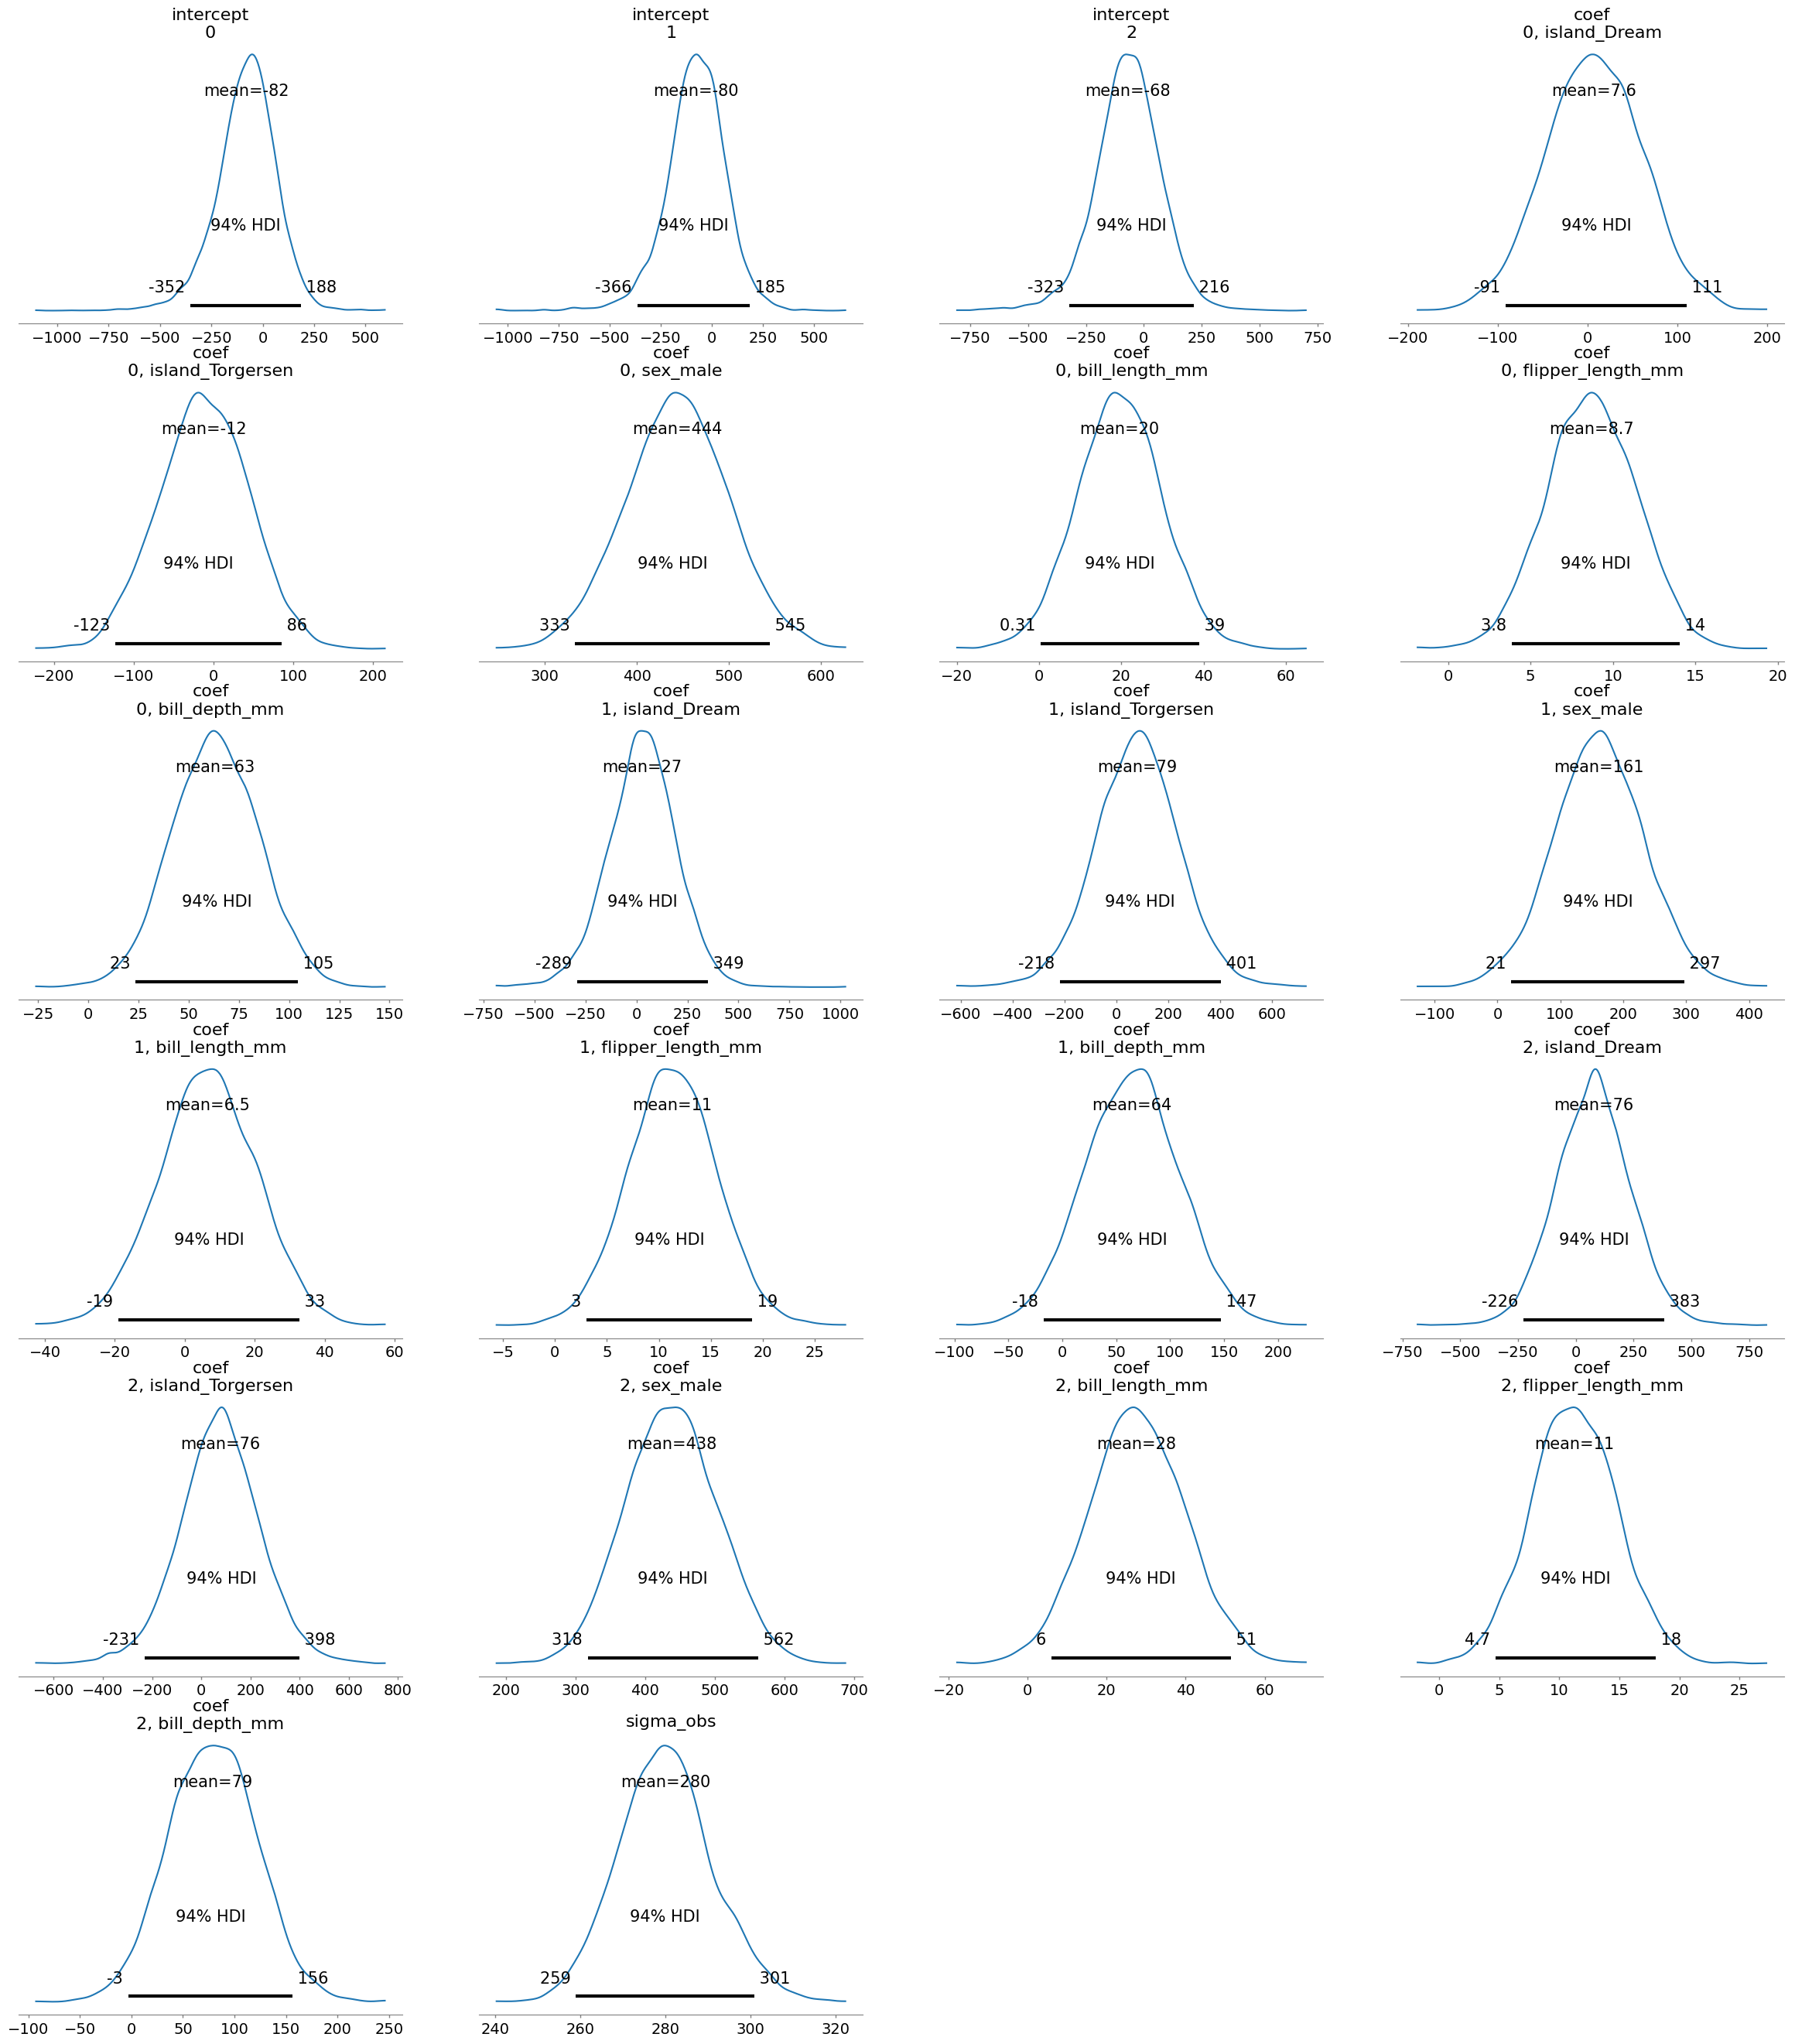

In [ ]:
az.plot_posterior(trace_separate, var_names=["intercept", "coef", "sigma_obs"])

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

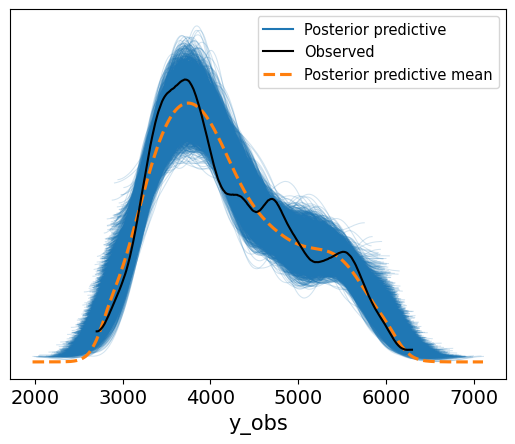

In [27]:
# posterior predictive check
with model_separate:
    ppc_separate = pm.sample_posterior_predictive(trace_separate, var_names=["y_obs"])

az.plot_ppc(ppc_separate, observed=True)

## Model comparison

In [ ]:
# compare
az.compare({"pooled": trace_pooled, "hierarchical": trace_separate})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-2359.284278,13.742626,0.000000,0.885015,13.422424,0.000000,False,log
pooled,1,-2377.557711,7.125274,18.273432,0.114985,12.865672,6.826213,False,log


In [ ]:
# WAIC for hierarchical model
az.waic(trace_separate)

/Users/shiotanitenshou/Study/bayesian_computation_book/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 333 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2359.17    13.42
p_waic       13.63        -

There has been a warning during the calculation. Please check the results.

In [30]:
# WAIC for pooled model
az.waic(trace_pooled)

Computed from 4000 posterior samples and 333 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2377.54    12.86
p_waic        7.11        -